# Load our data in and take a look at both the raw data and also visualize it

In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
silsoJD = pd.read_csv('./sunspot_data/SILSO_daily_inJD.txt', delimiter='\s+', usecols=[0,1,2,3,4], skiprows=1)

silsoJD.columns = ['JD', 'SSN', 'std', 'observations', 'definitive indicator']

In [20]:
silsoJD

,JD,SSN,std,observations,definitive indicator
0,2385070.5,-1.0,-1.0,0.0,1.0
1,2385071.5,-1.0,-1.0,0.0,1.0
2,2385072.5,-1.0,-1.0,0.0,1.0
3,2385073.5,-1.0,-1.0,0.0,1.0
4,2385074.5,-1.0,-1.0,0.0,1.0
...,...,...,...,...,...
73865,2458935.5,0.0,0.0,43.0,0.0
73866,2458936.5,0.0,0.0,39.0,0.0
73867,2458937.5,0.0,0.0,36.0,0.0
73868,2458938.5,4.0,0.2,9.0,0.0


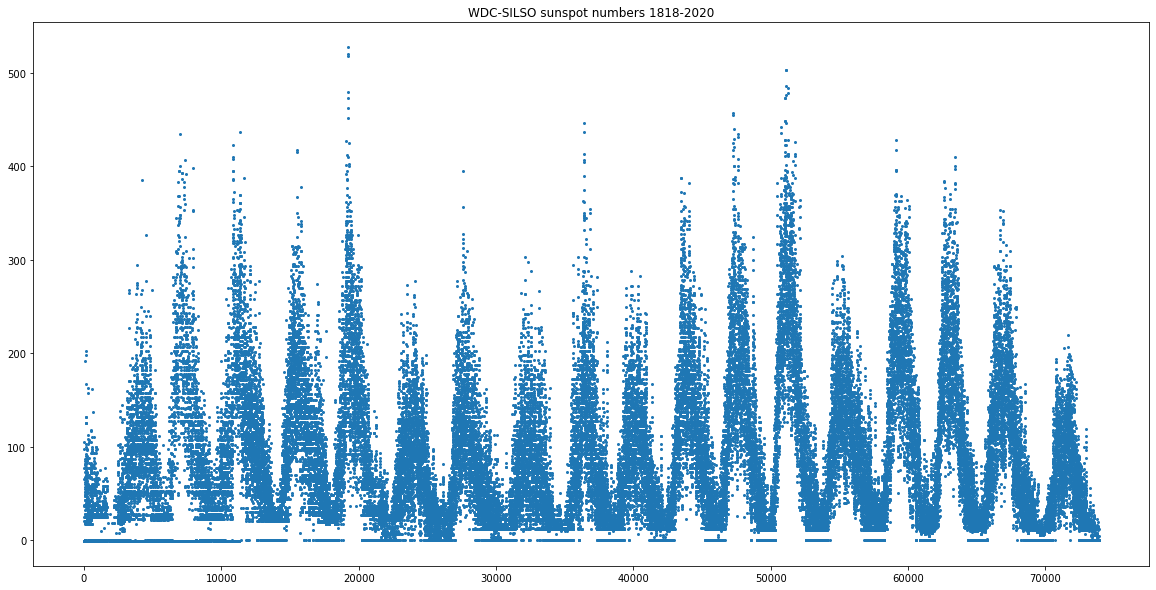

In [229]:
plt.figure(figsize=(20,10))
plt.title('WDC-SILSO sunspot numbers 1818-2020')
plt.scatter(range(len(silsoJD['SSN'])), silsoJD['SSN'], s=4)

#note: value of -1 means no data collected that day. need to cut out

## Take care of that note and clean it up, doesn't really make much of a difference but we'll be thorough anyway

In [201]:
cleaned_data = silsoJD['SSN'].replace(-1.0, np.nan)
dates = [date for date in range(len(silsoJD['SSN']))]

## Some naive guesses at what a model might look like, keep tweaking and adding sine functions until something is reasonable enough to move forward with

In [205]:
#convert to degrees for np.sin because it makes more sense in my head
dates_deg = [date*np.pi/180 for date in dates]

period1 = (len(dates)/360) / 18.33 #number of periods (in degrees) divided by how many i counted by eye 
phase1 =  np.pi - np.arcsin(0.25)  #around where the function starts (back to radians because i hate myself)
func1arg = [date/period1 + phase1 for date in dates_deg]

period2 = (len(dates)/360) / 1.75
phase2 =  np.arcsin(0.25)
func2arg = [date/period2 + phase2 for date in dates_deg]

#units are counts
amplitude1 = 180 
amplitude2 = 60

offset1 = 70
offset2 = 70

function1 = (amplitude1 * (np.sin(func1arg)) + offset1)
function2 = (amplitude2 * (np.sin(func2arg)) + offset2)

total_function = (function1 + function2) + silsoJD['std']
total_function[total_function <0] = 0

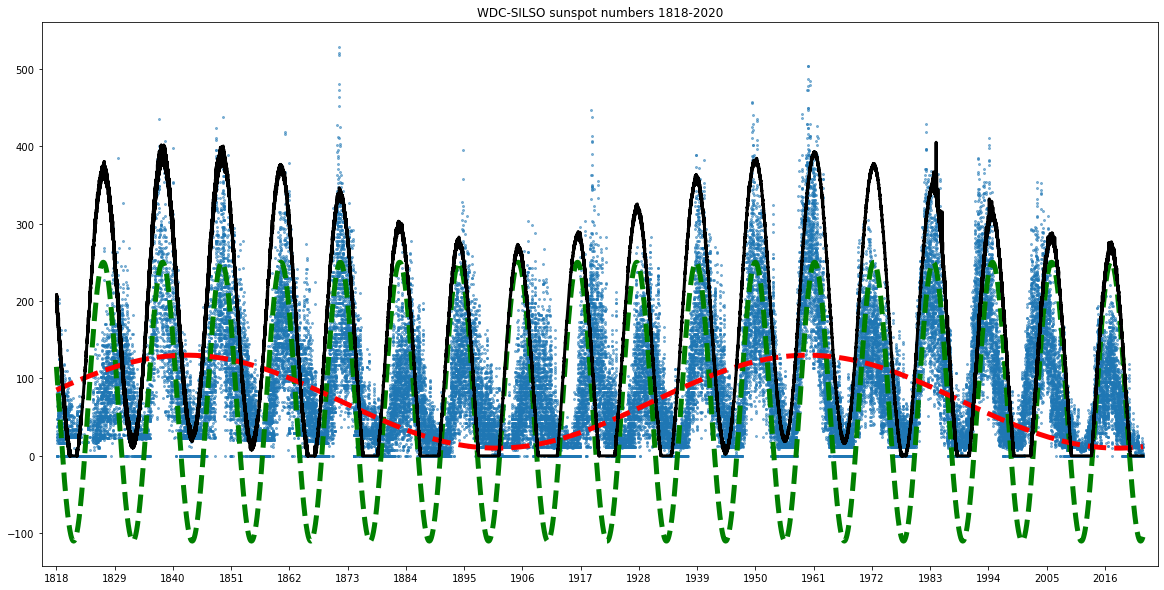

In [206]:
fig = plt.figure(figsize=(20,10))
plt.title('WDC-SILSO sunspot numbers 1818-2020')
plt.xticks(np.arange(0, len(dates), 11*360), labels=np.arange(1818,2020, 11))
plt.xlim(-1000, len(dates)+1000)
plt.scatter(dates, cleaned_data, s=4, alpha=0.5)
plt.plot(dates, function1, c='g', ls='--', linewidth=5)
plt.plot(dates, function2, c='r', ls='--', linewidth=5)
plt.plot(dates, total_function, c='k', linewidth=3)

### Here's what a model for this probably looks like:

$$
SSN(t) = \left(A_1\! \sin(B_1t + C_1) + D_1\right) \ + \ \left(A_2\! \sin(B_2t + C_2) + D_2\right) \ + \ ...
$$

Where $A$ is amplitude, $B$ is period, $C$ is our phase shift, and $D$ is our displacement. For this project, we'll only focus on the 2 obvious cycles in this data: the commonly known ~11 year cycle, and what appears to be a cycle of around 115 years. Evidence suggests longer cycles such as:

- The 210 year Suess cycle
- The ~2,400 year Hallstatt cycle
- Cycles of various years including (105, 131, 232, 385, etc.)
- Unnamed cycle of possibly >6,000 years

A lot of these cycles look at radiocarbon dating, and geological observations. We're only dealing with recorded sunspot numbers from visual observations from the past 200 years so it isn't prudent to consider them for this modeling.

## That being said, now we can make a Metropolis-Hastings code to sample our functions and have that come up with a better fit...........maybe


In [ ]:
# we'll define a chisq function for scipy optimize
def chisq(x, *args):
    I_0, p, tmax, tE = x
    t, y, dy = args
    mod = logmodel(I_0, p, tmax, tE, t)
    chisq = np.sum(((y - mod)**2.)/(dy**2.))/(len(t) -4)
    return chisq
    
# and a log likelihood function for our Metropolis-Hastings implementation
def LogLikelihood(I_0, p, tmax, tE, t, y, dy):
    x = (I_0, p, tmax, tE)
    args = (t, y, dy)
    negLogLike = chisq(x, *args)
    return -negLogLike/2.

# we'll set some very loose bounds on each parameter
bounds = [(16, 18), (0, 2), (2458400, 2458600), (10, 60)]

# we need to pass the data to scipy.optimize
args = (data['t'], data['y'], data['dy'])

res = so.minimize(chisq, guess, args=args, bounds=bounds)
print(res)

# and we can use the Hessian inverse to set the step size for metropolis-hastings
# this choice is good because it should ensure we sample the distribution well.
sigmas = np.diag(res.hess_inv.todense())**0.5
print('Sigmas =', sigmas)

Further things that could be done: (Frank attempting Fourier component analysis?)

-Refine our model. In reality, the period seems to vary from one cycle to another. Instead of it being in the form of 
$$
SSN(t) = \left(A_1\! \sin(B_1t + C_1) + D_1\right) \ + \ \left(A_2\! \sin(B_2t + C_2) + D_2\right) \ + \ ...
$$

a more accurate model might be a similar series but of finite lengths of time, instead of overarching periodic functions that last forever:

$$
SSN(t) = \left(A_1\! \sin(B_1(t_1 -t_2) + C_1) + D_1\right) \ + \ \left(A_2\! \sin(B_2(t_3-t_4) + C_2) + D_2\right) \ + \ ...
$$